# MRI brain tumor segmentation
 **Using Mask R-CNN for brain tumor detection and segmentation**
 
 Following the [Mask R-CNN](https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb) tutorial to perform configurations and set up model 

# Import libraries and setup environment

In [1]:
!pip install imutils
# Using shapes example from Mask R-CNN tutorial, code builds for older versions of ts and keras, so:
#!pip install tensorflow==1.14.0  # add older version of TF
#!pip install keras==2.2.4 # older version of Keras
#!pip install -U scikit-image==0.16.2 # due to some warning with newer version

!pip install pycocotools

# import libs
import os
import re
import sys
import cv2
import glob 
import time
import json
import math
import random
import imutils
import itertools
import matplotlib
import numpy as np # linear algebra
import skimage.draw
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from tqdm import tqdm
import matplotlib.cm as cm
from skimage.io import imread
import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
from imgaug import augmenters as iaa

from IPython.display import clear_output

!git clone https://github.com/matterport/Mask_RCNN.git # load Mask R-CNN code implementation
!git clone https://github.com/rastislavkopal/brain-tumor-segmentation.git # load manually annotated data from git repo
    
    
!rm -rf brain-tumor-segmentation/.git/
!rm -rf Mask_RCNN/.git/

clear_output()

In [5]:
# Import libraries needed for Mask R-CNN 

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")
#!python setup.py -q install

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = 'logs' 

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Import COCO config  
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

plt.rcParams['figure.facecolor'] = 'white'

DATASET_DIR = './brain-tumor-segmentation/brain_tumor_data/'
    
clear_output()

# Dataset example
* Brain images with its segment of tumor undetneath

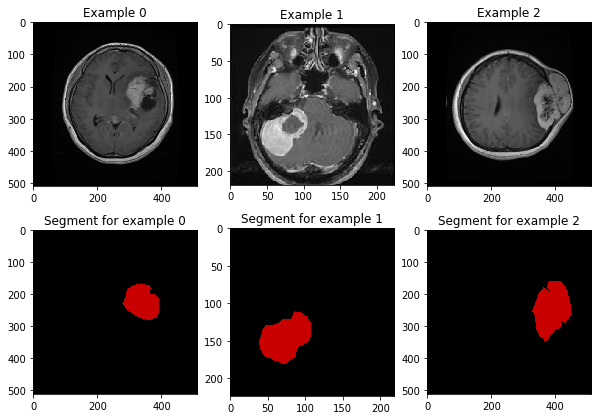

In [4]:
examples = [Image.open(DATASET_DIR + 'train/100.jpg'),Image.open(DATASET_DIR + 'train/116.jpg'),
Image.open(DATASET_DIR+'train/221.jpg')]
examplesSeg = ['100.jpg20477','116.jpg10596','221.jpg19584']

## print some example images from train directory
fig = plt.figure(figsize=(10,14))

for i in range(0, len(examples)):
    a = fig.add_subplot(1, 3, i+1)
    imgplot = plt.imshow(examples[i])
    a.set_title('Example '+str(i))

## print segment examples for images from json annotations file
with open(DATASET_DIR+'train/annotations.json') as json_file:
    data = json.load(json_file)
    for i in range(0,len(examplesSeg)):
        # load regions from json file and transform them into (x,y) coordinates
        coord = list(zip(data[examplesSeg[i]]['regions'][0]['shape_attributes']
        ['all_points_x'],data[examplesSeg[i]]['regions'][0]['shape_attributes']['all_points_y'])) 
        image = Image.new("RGB", np.asarray(examples[i]).shape[0:2])
        draw = ImageDraw.Draw(image)
        draw.polygon((coord), fill=200)
        a = fig.add_subplot(2, 3, 3+i+1)
        imgplot = plt.imshow(image)
        a.set_title('Segment for example ' + str(i))


**Number of data used for training**
* Bar chart of dataset size for each folder train/test/val

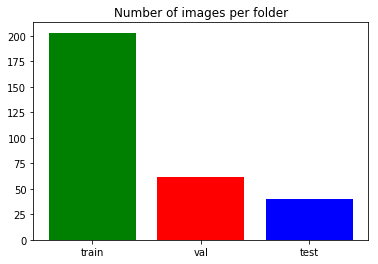

In [5]:
# show number of data for each dir 
def showDataLayout():
    values = dict()
    for file in os.listdir(DATASET_DIR):
        values[str(file)] = len(os.listdir('./brain-tumor-segmentation/brain_tumor_data/' + file))
    plt.title('Number of images per folder')
    plt.bar(range(len(values)), list(values.values()), align='center',color=[ 'green','red', 'blue'])
    plt.xticks(range(len(values)), list(values.keys()))
    plt.show()
        
    
showDataLayout()

# Data preprocessing // TODO
* Background removal via finding extreme point in contours [explained here](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)
* Skull removal to not detect bones -> eyes, etc

# Training configurations for our model

In [6]:
class TrainConfig(Config):
    """Configuration for training on the brain tumor dataset.
    Derives from the base Config class and overrides values specific
    to the brain tumor dataset.
    """
    # Give the configuration a recognizable name
    NAME = "tumor_detect"

    # Train on 1 GPU and 1 images per GPU. 1 Image per CPU since the images are 
    # of bigger size. ### Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # background + 1 class of tumor

    
    DETECTION_MIN_CONFIDENCE = 0.7   

    LEARNING_RATE = 0.001

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Override the Mask R-CNN Dataset class 
**Create a synthetic dataset for our own brain tumor dataset**

Extend the Dataset class and add a method to load the shapes dataset, load_shapes(), and override the following methods:
* load_image()
* load_mask()
* image_reference()

In [7]:
class TumorDataset(utils.Dataset):
    """Generates the brain tumors dataset and json annotations. 
    """
    def load_brain_tumor_images(self, dataset_dir, folder):
        self.add_class("tumor", 1, "tumor")
        
        assert folder in ["train", "val", 'test']
        
        dataset_dir = os.path.join(dataset_dir,folder)
        
        annotations = json.load(open(os.path.join(dataset_dir,'annotations.json')))
        
        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]
        
        for i in annotations:
            polygons = [r['shape_attributes'] for r in i['regions']] 
            # get segmented regions from json file
            
            image_path = os.path.join(dataset_dir, i['filename']) 
            # load correspending image for loaded json object and save it's size
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            # set jsons's 'filename' property as unique identifier since its same as original image name
            # using only 'tumor' class/object
            self.add_image('tumor', image_id=i['filename'], width=width, height=height, path=image_path,
            polygons=polygons)

            
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        This function loads the image from a file with given image_id
        """
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image
    
   # info = self.image_info[image_id]
   # bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
   # image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
   # image = image * bg_color.astype(np.uint8)
   # for shape, color, dims in info['shapes']:
   #     image = self.draw_shape(image, shape, dims, color)
   # return image
    

    def load_mask(self, image_id):
        """Return instance masks for brain image of the given ID.
        """
        # If not a tumor dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count] 
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])],
        dtype=np.uint8)
        for i, p in enumerate(image_info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)
            

# Create training,validation and test data generators

In [8]:
# Train dataset generator
dataset_train = TumorDataset()
dataset_train.load_brain_tumor_images(DATASET_DIR,'train')
dataset_train.prepare()

# Validation dataset
dataset_val = TumorDataset()
dataset_val.load_brain_tumor_images(DATASET_DIR,'val')
dataset_val.prepare()

# Test dataset
dataset_test = TumorDataset()
dataset_test.load_brain_tumor_images(DATASET_DIR,'test')
dataset_test.prepare()

# Define Model 
**We are going to use the 'Coco' weights**

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

# Training the network

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=18, 
            layers='heads')

# Save weights not needed since -> callbacks save after every epoch


Starting at epoch 0. LR=0.001

Checkpoint Path: /kaggle/working/Mask_RCNN/logs/tumor_detect20240331T0909/mask_rcnn_tumor_detect_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistrib

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 1/18
100/100 [==============================] - 71s 705ms/step - loss: 1.8386 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.7437 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.5557 - mrcnn_mask_loss: 0.4167 - val_loss: 2.1693 - val_rpn_class_loss: 0.0363 - val_rpn_bbox_loss: 0.5146 - val_mrcnn_class_loss: 0.1686 - val_mrcnn_bbox_loss: 0.8835 - val_mrcnn_mask_loss: 0.5662
Epoch 2/18
100/100 [==============================] - 34s 338ms/step - loss: 0.9174 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.3277 - mrcnn_mask_loss: 0.2852 - val_loss: 1.4934 - val_rpn_class_loss: 0.0036 - val_rpn_bbox_loss: 0.1687 - val_mrcnn_class_loss: 0.0279 - val_mrcnn_bbox_loss: 0.8392 - val_mrcnn_mask_loss: 0.4540
Epoch 3/18
100/100 [==============================] - 33s 330ms/step - loss: 1.1015 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3976 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.3073 - val_loss: 1.4824 - val_rpn_c

**Recreate the model in inference mode**

In [19]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights // specify path or load last
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/Mask_RCNN/logs/tumor_detect20240331T0909/mask_rcnn_tumor_detect_0018.h5
Re-starting from epoch 18


# Results - Detection

In [20]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

In [21]:
def get_ax(rows=1, cols=1, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [22]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)
    

# Results - Evaluation

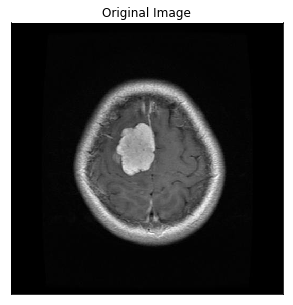

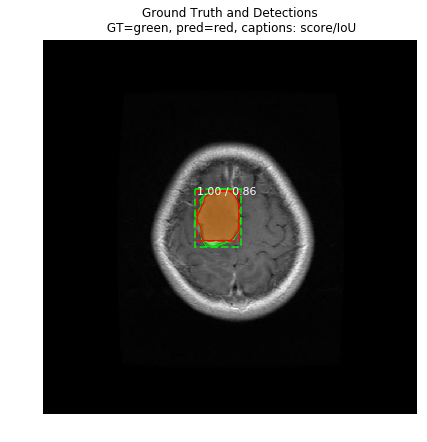

In [23]:
display_image(dataset_val, 0)
predict_and_plot_differences(dataset_val, 0)

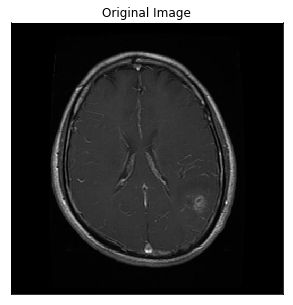

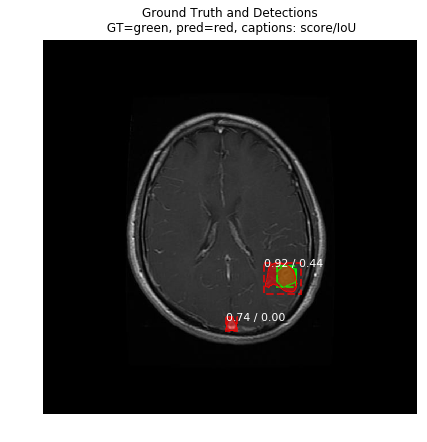

In [24]:
display_image(dataset_val, 1)
predict_and_plot_differences(dataset_val, 1)

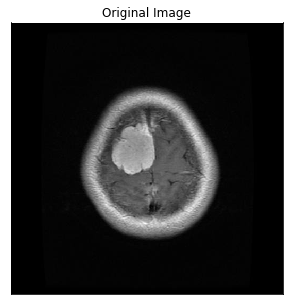

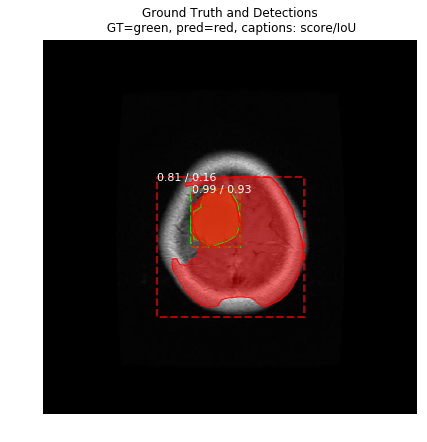

In [25]:
display_image(dataset_val, 2)
predict_and_plot_differences(dataset_val, 2)

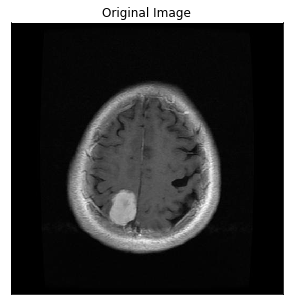

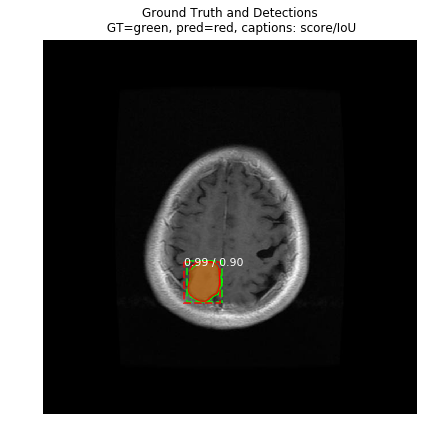

In [26]:
display_image(dataset_val, 9)
predict_and_plot_differences(dataset_val, 9)

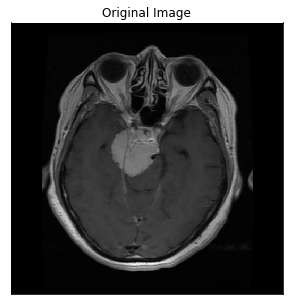

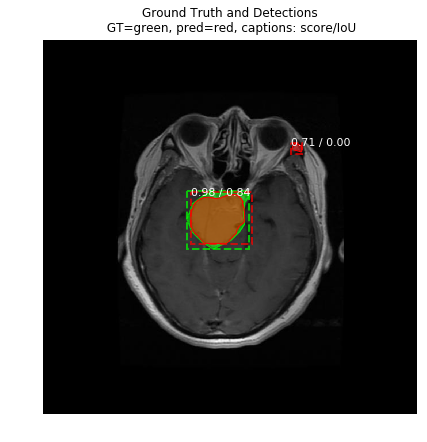

In [27]:
display_image(dataset_val, 42)
predict_and_plot_differences(dataset_val, 42)

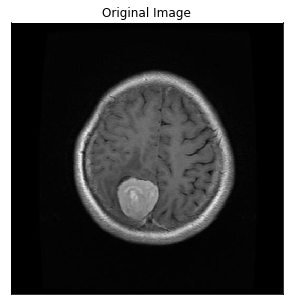

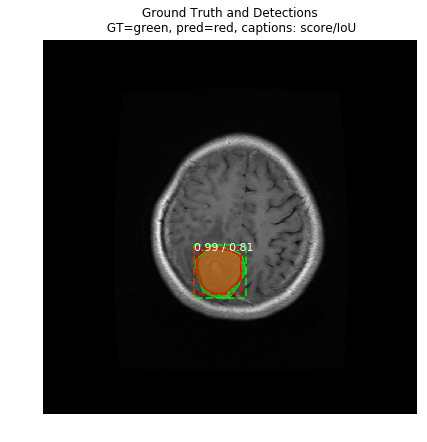

In [28]:
display_image(dataset_val, 58)
predict_and_plot_differences(dataset_val, 58)

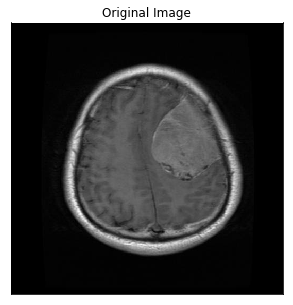

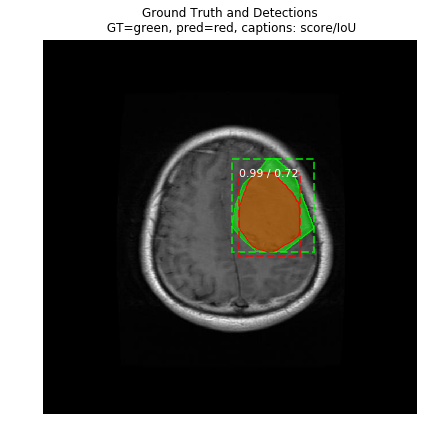

In [29]:
display_image(dataset_val,19)
predict_and_plot_differences(dataset_val, 19)